In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# Create embedding for epochs
class SinusoidalEmbedding(nn.Module):
  def __init__(self, size: int, scale: float = 1.0):
    super().__init__()
    self.size = size
    self.scale = scale

  def forward(self, x: torch.Tensor):
    x = x * self.scale
    half_size = self.size // 2
    emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
    emb = torch.exp(-emb * torch.arange(half_size))
    emb = x.unsqueeze(-1) * emb.unsqueeze(0)
    emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
    return emb

  def __len__(self):
    return self.size

In [24]:
epochs_embeddings = {}
embedder = SinusoidalEmbedding(64)


for epoch in range(1, 16):
  embedding = embedder(torch.tensor(epoch))
  epochs_embeddings[epoch] = embedding

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset, DataLoader

DATA_PATH = f'./drive/MyDrive/CS 8395 - C-DiffNet/MNIST_Epochs/consolidated_new_data/'

all_params = []
for epoch in range(10):
  params = np.load(DATA_PATH + f'epoch_{epoch+1}')

  for arr in params:
    all_params.append(arr)
  print("Loading epoch", epoch)


Loading epoch 0
Loading epoch 1
Loading epoch 2
Loading epoch 3
Loading epoch 4
Loading epoch 5
Loading epoch 6
Loading epoch 7
Loading epoch 8
Loading epoch 9


In [26]:
all_params = np.array(all_params)
print(all_params.shape)
scaler = MinMaxScaler()
normalized_params = scaler.fit_transform(all_params)
print(normalized_params)

(500, 330)
[[0.91291165 0.85952294 0.         ... 0.6379963  0.70535535 0.22213599]
 [0.85605055 0.11474353 0.3588639  ... 0.13250868 1.         0.44889742]
 [0.58366144 0.39602464 0.07955241 ... 0.33309135 0.8914851  0.7253901 ]
 ...
 [0.2642097  0.65956026 1.         ... 0.83332115 0.5437895  0.7571454 ]
 [0.74230444 0.5722306  0.63944596 ... 0.38546246 0.44860834 0.750087  ]
 [0.58781177 0.44417185 0.6336757  ... 0.67554975 0.44685516 0.9570945 ]]


In [27]:
epochs_to_params = {}


start = 0
for epoch in range(1, 11):
  epoch_set = normalized_params[start:start+50]

  start += 50

  epochs_to_params[epoch] = epoch_set

print(epochs_to_params)

{1: array([[0.91291165, 0.85952294, 0.        , ..., 0.6379963 , 0.70535535,
        0.22213599],
       [0.85605055, 0.11474353, 0.3588639 , ..., 0.13250868, 1.        ,
        0.44889742],
       [0.58366144, 0.39602464, 0.07955241, ..., 0.33309135, 0.8914851 ,
        0.7253901 ],
       ...,
       [0.2642097 , 0.44663572, 0.75017196, ..., 0.4594907 , 0.86048865,
        0.5152766 ],
       [0.74230444, 0.41870865, 0.61651254, ..., 0.12609018, 0.83977246,
        0.54681516],
       [0.58781177, 0.24515556, 0.43144098, ..., 0.3216883 , 0.77888966,
        0.749425  ]], dtype=float32), 2: array([[0.91291165, 0.9050565 , 0.01035017, ..., 0.6768329 , 0.65680057,
        0.26966664],
       [0.85605055, 0.1941852 , 0.394574  , ..., 0.15928346, 0.9710764 ,
        0.49753368],
       [0.58366144, 0.47491086, 0.10228911, ..., 0.36424893, 0.8517085 ,
        0.7920793 ],
       ...,
       [0.2642097 , 0.5010693 , 0.7404768 , ..., 0.49464026, 0.8257036 ,
        0.55836624],
       [0.74

In [28]:
train_data = []
for epoch in epochs_to_params:
  for params in epochs_to_params[epoch]:

    train_data.append((torch.tensor([params]), epochs_embeddings[epoch]))

params = torch.cat([x[0] for x in train_data], dim=0)
embeddings = torch.cat([x[1] for x in train_data], dim=0)
print(params)
print(embeddings)

train_dataset = TensorDataset(params, embeddings)
train_loader = DataLoader(train_dataset, batch_size = 10)
#train_dataset = TensorDataset(torch.cat([x[0] for x in train_data], dim=0), torch.cat([x[1] for x in train_data], dim=0))

tensor([[0.9129, 0.8595, 0.0000,  ..., 0.6380, 0.7054, 0.2221],
        [0.8561, 0.1147, 0.3589,  ..., 0.1325, 1.0000, 0.4489],
        [0.5837, 0.3960, 0.0796,  ..., 0.3331, 0.8915, 0.7254],
        ...,
        [0.2642, 0.6596, 1.0000,  ..., 0.8333, 0.5438, 0.7571],
        [0.7423, 0.5722, 0.6394,  ..., 0.3855, 0.4486, 0.7501],
        [0.5878, 0.4442, 0.6337,  ..., 0.6755, 0.4469, 0.9571]])
tensor([[ 0.8415,  0.6765,  0.5244,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.8415,  0.6765,  0.5244,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.8415,  0.6765,  0.5244,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.5440,  0.9113, -0.6913,  ...,  1.0000,  1.0000,  1.0000],
        [-0.5440,  0.9113, -0.6913,  ...,  1.0000,  1.0000,  1.0000],
        [-0.5440,  0.9113, -0.6913,  ...,  1.0000,  1.0000,  1.0000]])


In [29]:
class ConditionalVAE(nn.Module):
  def __init__(self, input_dim, latent_dim, condition_dim):
    super(ConditionalVAE, self).__init__()
    self.latent_dim = latent_dim
    self.input_dim = input_dim

    self.d = nn.Dropout(0.5)

    # Encoder
    self.encoder = nn.Sequential(
        nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(25216, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, 2*latent_dim)      # Gives 10x128 output tensor
    )

    # Decoder
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim + 64, 256),
        nn.ReLU(),
        nn.Linear(256, self.input_dim * 64),  # Matching the flattened size of the encoder's last conv output
        nn.BatchNorm1d(self.input_dim * 64),
        nn.ReLU(),
        nn.Unflatten(1, (self.input_dim, 64)),  # Restore to [channels, length]
        nn.ConvTranspose1d(self.input_dim, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsample
        nn.ReLU(),
        nn.ConvTranspose1d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.ConvTranspose1d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=0),
        nn.Flatten(),
        nn.Linear(255, self.input_dim),
        nn.Sigmoid()
    )


  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x, c):
    x = self.d(x)

    xc = torch.cat([x, c], dim=2)
    encoded = self.encoder(xc)
    mu, log_var = encoded.chunk(2, dim=-1)
    z = self.reparameterize(mu, log_var)

    zc = torch.cat([z, c.squeeze(1)], dim=1)
    return self.decoder(zc), mu, log_var

In [30]:
input_dim = 330
latent_dim = 64
condition_dim = 64


def loss_func(reconstructed, params, mu, log):
  bce = nn.functional.binary_cross_entropy_with_logits(reconstructed, params, reduction='sum')
  kld = -0.5 * torch.sum(1 + log - mu.pow(2) - log.exp())
  return bce + kld


cvae = ConditionalVAE(input_dim, latent_dim, condition_dim)
optimizer = torch.optim.AdamW(cvae.parameters(), lr=1e-4)

epochs = 20

for e in range(epochs):
  cvae.train()

  curr_loss = 0

  for params, embeds in train_loader:
    optimizer.zero_grad()
    params_reconstructed, mu, log = cvae(params.unsqueeze(1), embeds.unsqueeze(1))
    loss = loss_func(params_reconstructed, params, mu, log)
    loss.backward()
    curr_loss += loss.item()
    torch.nn.utils.clip_grad_norm_(cvae.parameters(), max_norm=1.0)
    optimizer.step()
  print(params)
  print(params_reconstructed)
  print(f'Epoch {e}, Loss: {curr_loss / len(train_loader.dataset)}')

tensor([[0.2619, 0.7988, 0.5124,  ..., 0.4383, 0.1310, 0.9640],
        [0.6737, 0.5710, 0.6189,  ..., 0.5626, 0.3830, 0.8419],
        [0.8031, 0.7988, 0.3954,  ..., 0.8291, 0.1800, 0.6834],
        ...,
        [0.2642, 0.6596, 1.0000,  ..., 0.8333, 0.5438, 0.7571],
        [0.7423, 0.5722, 0.6394,  ..., 0.3855, 0.4486, 0.7501],
        [0.5878, 0.4442, 0.6337,  ..., 0.6755, 0.4469, 0.9571]])
tensor([[0.0175, 0.6852, 0.3169,  ..., 0.0862, 0.2292, 0.6217],
        [0.0295, 0.6402, 0.2142,  ..., 0.1032, 0.1352, 0.5391],
        [0.0280, 0.7585, 0.2782,  ..., 0.1356, 0.1380, 0.4814],
        ...,
        [0.0081, 0.6137, 0.2350,  ..., 0.0717, 0.0592, 0.4697],
        [0.0183, 0.6546, 0.2894,  ..., 0.1090, 0.0966, 0.5422],
        [0.0214, 0.7389, 0.2134,  ..., 0.1581, 0.1009, 0.4665]],
       grad_fn=<SigmoidBackward0>)
Epoch 0, Loss: 240.36181005859376
tensor([[0.2619, 0.7988, 0.5124,  ..., 0.4383, 0.1310, 0.9640],
        [0.6737, 0.5710, 0.6189,  ..., 0.5626, 0.3830, 0.8419],
       

In [31]:
print("Min and Max of recon_params:", params_reconstructed.min().item(), params_reconstructed.max().item())
print("Min and Max of params:", params.min().item(), params.max().item())
print("Min and Max of mu:", mu.min().item(), mu.max().item())
print("Min and Max of log_var:", log.min().item(), log.max().item())

Min and Max of recon_params: 0.0004312451055739075 0.9978938698768616
Min and Max of params: 0.0 1.0000001192092896
Min and Max of mu: -0.16312867403030396 0.1547442227602005
Min and Max of log_var: -0.1545161008834839 0.13200144469738007


In [42]:
# Do a test accuracy where we train all the way through 5 epochs,
# test accuracy for that, then replace with predicted params

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [43]:
# Function to test model accuracy
def get_test_accuracy(model, test_loader):

  model.eval()
  correct = 0
  total = 0

  for images, labels in test_loader:
    preds = model(images)
    real_vals = torch.argmax(preds, dim=-1)
    total += len(preds)
    cs = (real_vals == labels).sum().item()

    correct += cs

  return 100 * correct / total

In [44]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()

    self.l1 = nn.Linear(28*28, 100)
    self.l2 = nn.Linear(100, 50)
    self.l3 = nn.Linear(50, 32)
    self.classifier = nn.Linear(32, 10)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = self.activation(self.l1(x))
    x = self.activation(self.l2(x))
    x = self.activation(self.l3(x))
    out = self.classifier(x)
    return out

# mlp = MLP()

# mlp.load_state_dict(torch.load('./drive/MyDrive/CS 8395 - C-DiffNet/MNIST_Epochs/model'))


In [34]:
# import math

# model_loss_function = nn.CrossEntropyLoss()

# mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

# stdv = 1. / math.sqrt(mlp.classifier.weight.size(1))
# mlp.classifier.weight.data.uniform_(-stdv, stdv)
# if mlp.classifier.bias is not None:
#     mlp.classifier.bias.data.uniform_(-stdv, stdv)

# for name, params in mlp.named_parameters():
#   if name not in ['classifier.weight', 'classifier.bias']:
#     params.requires_grad = False
#   else:
#     print(True)

# for e in range(1, 6):
#   mlp.train()
#   for images, labels in train_loader:
#     mlp_optimizer.zero_grad()
#     preds = mlp(images)
#     loss = model_loss_function(preds, labels)

#     loss.backward()
#     mlp_optimizer.step()
#   print(f"Epoch {e} complete training")

In [36]:
# regular_accuracy = get_test_accuracy(mlp, test_loader)
# print("Regular accuracy after 5 epochs: ", regular_accuracy)

In [35]:
# # Now, let's try and adjust the last set of parameters
# cvae.eval()
# epoch_num = 5
# c = embedder(torch.tensor([epoch_num])).unsqueeze(1)

# z = torch.randn(1, latent_dim)

# zc = torch.cat([z, c.squeeze(1)], dim=1)

# generated_params_normed = cvae.decoder(zc)
# generated_params = scaler.inverse_transform(generated_params_normed.detach().numpy())
# generated_params = torch.tensor(generated_params, dtype=torch.float)
# weights = (generated_params[0][:32*10].reshape(10, 32))
# bias = generated_params[0][32*10:]
# weights = nn.Parameter(weights)
# bias = nn.Parameter(bias)

# # print(mlp.classifier.weight)
# print(weights)

In [37]:
# mlp.classifier.weight = weights
# mlp.classifier.bias = bias

# print(mlp.classifier.weight)
# print(weights)
# print(bias)

In [38]:
# generated_accuracy = get_test_accuracy(mlp, test_loader)
# print("Generated accuracy after 5 epochs: ", generated_accuracy)

In [53]:
import math
generated_accuracies = []
regular_accuracies = []
model_loss_function = nn.CrossEntropyLoss()
cvae.eval()

# for t in range(1, 11):
mlp = MLP()
mlp.load_state_dict(torch.load('./drive/MyDrive/CS 8395 - C-DiffNet/MNIST_Epochs/model'))

stdv = 1. / math.sqrt(mlp.classifier.weight.size(1))
mlp.classifier.weight.data.uniform_(-stdv, stdv)
if mlp.classifier.bias is not None:
    mlp.classifier.bias.data.uniform_(-stdv, stdv)

mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

for name, params in mlp.named_parameters():
  if name not in ['classifier.weight', 'classifier.bias']:
    params.requires_grad = False
  else:
    print(True)

for e in range(1, 11):
  mlp.train()
  for images, labels in train_loader:
    mlp_optimizer.zero_grad()
    preds = mlp(images)
    loss = model_loss_function(preds, labels)

    loss.backward()
    mlp_optimizer.step()

  regular_accuracy = get_test_accuracy(mlp, test_loader)
  print(f"Base accuracy at epoch {e}:", regular_accuracy)
  regular_accuracies.append(regular_accuracy)

True
True
Base accuracy at epoch 1: 96.78
Base accuracy at epoch 2: 97.13
Base accuracy at epoch 3: 97.28
Base accuracy at epoch 4: 97.36
Base accuracy at epoch 5: 97.35
Base accuracy at epoch 6: 97.37
Base accuracy at epoch 7: 97.47
Base accuracy at epoch 8: 97.43
Base accuracy at epoch 9: 97.38
Base accuracy at epoch 10: 97.42


In [54]:
mlp2 = MLP()
mlp2.load_state_dict(torch.load('./drive/MyDrive/CS 8395 - C-DiffNet/MNIST_Epochs/model'))
for name, params in mlp2.named_parameters():
  if name not in ['classifier.weight', 'classifier.bias']:
    params.requires_grad = False
  else:
    print(True)


for e in range(1, 11):
  mlp.train()
  c = embedder(torch.tensor([e])).unsqueeze(1)

  z = torch.randn(1, latent_dim)

  zc = torch.cat([z, c.squeeze(1)], dim=1)

  generated_params_normed = cvae.decoder(zc)
  generated_params = scaler.inverse_transform(generated_params_normed.detach().numpy())
  generated_params = torch.tensor(generated_params, dtype=torch.float)

  weights = (generated_params[0][:32*10].reshape(10, 32))
  bias = generated_params[0][32*10:]
  weights = nn.Parameter(weights)
  bias = nn.Parameter(bias)

  # orig_weights = mlp.classifier.weight
  # orig_bias = mlp.classifier.bias

  mlp2.classifier.weight = weights
  mlp2.classifier.bias = bias

  generated_accuracy = get_test_accuracy(mlp2, test_loader)
  generated_accuracies.append(generated_accuracy)
  print(f"Epoch {e} generated accuracy: {generated_accuracy}")

True
True
Epoch 1 generated accuracy: 96.63
Epoch 2 generated accuracy: 96.69
Epoch 3 generated accuracy: 96.66
Epoch 4 generated accuracy: 96.58
Epoch 5 generated accuracy: 96.77
Epoch 6 generated accuracy: 96.82
Epoch 7 generated accuracy: 96.7
Epoch 8 generated accuracy: 96.77
Epoch 9 generated accuracy: 96.68
Epoch 10 generated accuracy: 96.81


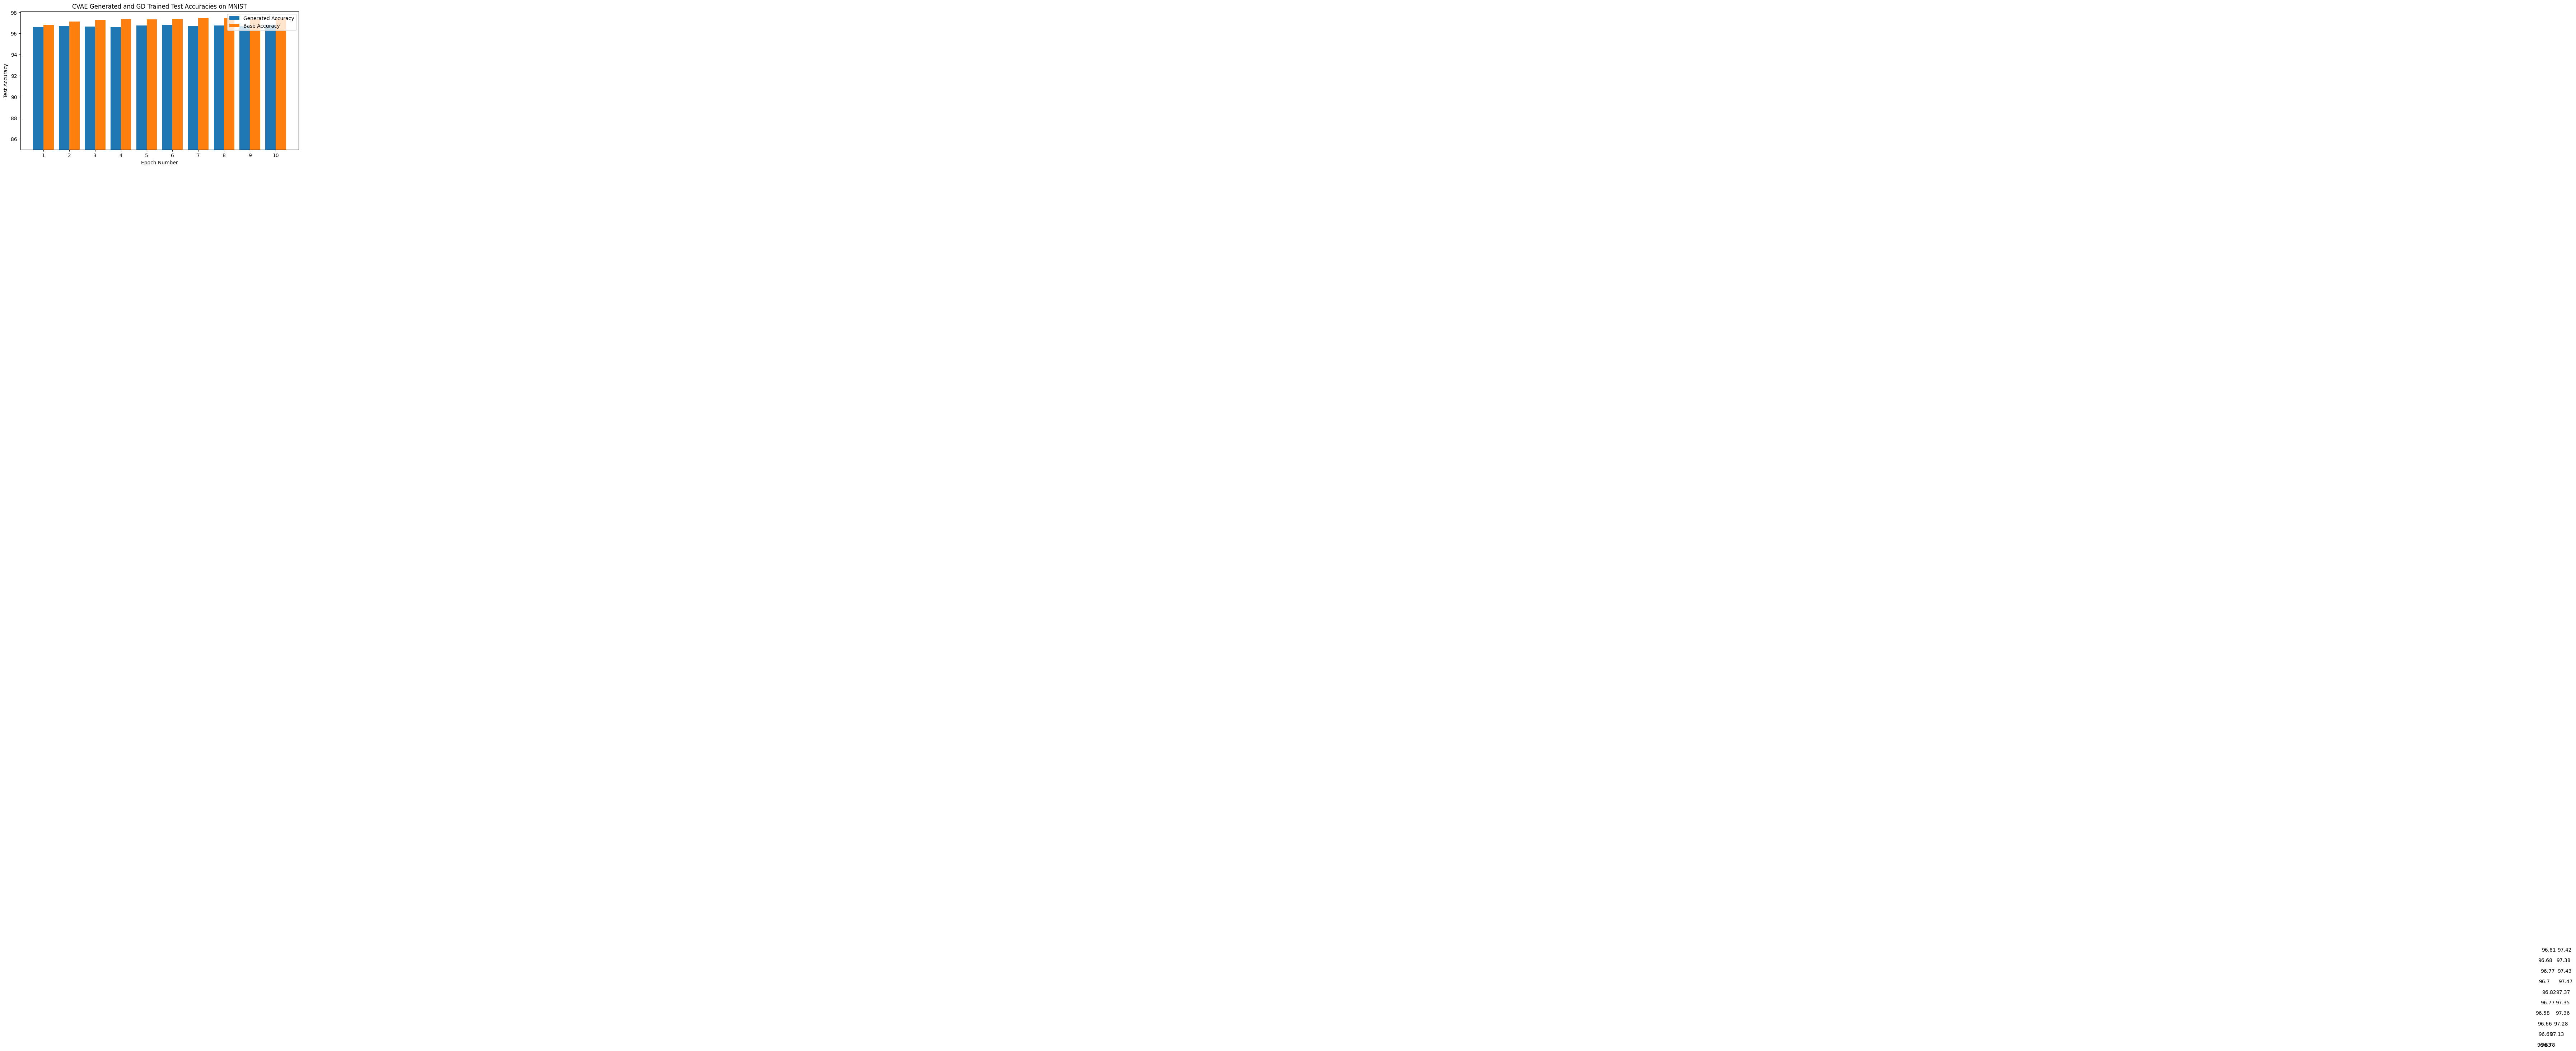

In [55]:
import matplotlib.pyplot as plt
labels = [i for i in range(1, 11)]

x_axis = np.arange(len(labels))
plot_generated = np.array(generated_accuracies) - np.array([85 for _ in range(10)])
plot_regular = np.array(regular_accuracies) - np.array([85 for _ in range(10)])

plt.figure(figsize=(10, 5))
plt.bar(x_axis - 0.2, plot_generated.tolist(), 0.4, label='Generated Accuracy', bottom=85)
plt.bar(x_axis + 0.2, plot_regular.tolist(), 0.4, label = 'Base Accuracy', bottom=85)

for index, value in enumerate(generated_accuracies):
    plt.text(value, index,
             str(value))
for index, value in enumerate(regular_accuracies):
    plt.text(value, index,
             str(value))

plt.xticks(x_axis, labels)
plt.xlabel("Epoch Number")
plt.ylabel("Test Accuracy")
plt.title("CVAE Generated and GD Trained Test Accuracies on MNIST")
plt.legend()
plt.show()